Lecture 17: Mixture Models vs Manifolds
===

In [ ]:
import numpy as np
from scipy import linalg
from sklearn import mixture
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import time
import sys
from IPython.display import display, clear_output

%matplotlib inline
#%matplotlib notebook

#Plot the clustering
def plot_clusters(labels, means, covars, X,i):
  
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        col = mpl.colors.rgb2hex(col[:3])
        class_member_mask = (labels == k)
        xy = X[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=5, alpha=0.5)

    plt.title('Clustering: Iteration %d'%(i))  

#Plot the clustering
def plot_cluster_comps(labels, means, covars, X,i):
  
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    plt.plot(X[:,0],X[:,1],'k.',alpha=0.5,markersize=1)
    
    for k, col in zip(unique_labels, colors):

        v, w = linalg.eigh(covars[k,:,:])
        u = w[0] / linalg.norm(w[0])
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        ell1 = mpl.patches.Ellipse(means[k,:], 2*np.sqrt(v[0]), 2*np.sqrt(v[1]), 180 + angle, color=col)
        ell1.set_alpha(0.8)
        ell2 = mpl.patches.Ellipse(means[k,:], 2*np.sqrt(v[0]), 2*np.sqrt(v[1]), 180 + angle, fill=False, color=col)
        ell2.set_alpha(1)

        plt.gca().add_artist(ell1)
        plt.gca().add_artist(ell2)

    plt.title('Clustering: Iteration %d'%(i)) 

def plot_density(xdims,ydims,pdf,title):
    
    #Prepare grid for plotting decision surface
    gx1, gx2 = np.meshgrid(np.arange(xdims[0], xdims[1],(xdims[1]-xdims[0])/100.0 ),
                           np.arange(ydims[0], ydims[1],(ydims[1]-ydims[0])/100.0 ),)
    gx1l = gx1.flatten()
    gx2l = gx2.flatten()
    gx   = np.vstack((gx1l,gx2l)).T

    #Compute a prediction for every point in the grid
    #Cache for fast redisplay
    y = np.exp(pdf.score_samples(gx))
    y = np.reshape(y,gx1.shape)
    
    #plt.gca().plot_surface(gx1, gx2, y, cmap=plt.cm.coolwarm,
    #                  linewidth=0, antialiased=True)
    
    plt.imshow(y, interpolation='nearest',
               extent=(xdims[0], xdims[1],ydims[0], ydims[1]), aspect='auto',
               origin='lower', cmap=plt.cm.coolwarm, alpha=1)
    
    #Plot a contour map of the function
    #plt.contourf(gx1, gx2, y, linewidths=2,linetypes='k-',
                #levels=np.round(np.linspace(0,np.sqrt(np.max(y)),10)**2)) 
    #plt.colorbar()
    #plt.contour(gx1, gx2, y, linewidths=2,linetypes='-',colors='k',
    #            levels=np.round(np.linspace(0,np.sqrt(np.max(y)),10)**2)) 
                     
    plt.xlabel('x1');
    plt.ylabel('x2');
    plt.grid(True)
    plt.title(title);

Generate Data
---

In [ ]:
#Set cluster compactness
std=0.1
n_samples=1000

# Generate cluster data
centers = [[1, 1], [-1, -1], [1, -1],[-1,1]]
X, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=std,random_state=0)
X = StandardScaler().fit_transform(X)

In [ ]:
#Generate manifold data
n_samples=1000
std=0.1
r      = 1 
theta  = 2*np.pi*np.random.rand(n_samples)
X      = np.zeros((n_samples,2)) 
X[:,0] = np.cos(theta)
X[:,1] = np.sin(theta)
X      = X + std*np.random.randn(n_samples,2)

Run Gaussian Mixture Model
---

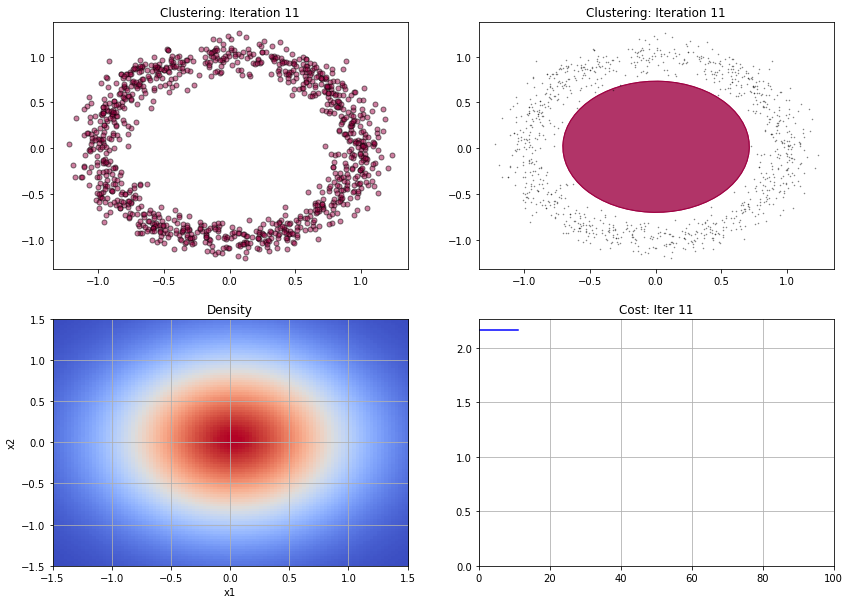

In [10]:
n_clusters=1 #Set Number of Clusters
L=1000 # Number of learning steps
cost = np.zeros(L) #Custering cost

#Randomly Initialize the Clusters
centers = (np.random.rand(n_clusters, 2)-0.5)
clf = mixture.GaussianMixture(n_components=n_clusters, means_init=centers, covariance_type='full', n_init=1, init_params="random", max_iter=1,warm_start=True)
clf.fit(X)

try:
    for i in range(L):

        means = clf.means_
        covars = clf.covariances_
        labels = clf.predict(X)
        cost[i] = -np.sum(clf.score(X))
        clf.fit(X)

        clear_output(wait=True)
        plt.figure(101,figsize=(14,10))
        plt.subplot(2,2,1)
        plot_clusters(labels, means, covars,X,i)

        plt.subplot(2,2,2)
        plot_cluster_comps(labels, means, covars,X,i)

        plt.subplot(2,2,3)
        plot_density([-1.5,1.5],[-1.5,1.5],clf,"Density")

        plt.subplot(2,2,4)
        plt.plot(cost[:i+1],'b-')
        plt.xlim(0,max(100,i))
        plt.ylim(0,1.05*max(cost[:i+1]))
        plt.title("Cost: Iter %d"%(i))
        plt.grid(True)

        plt.show()

        if(i>10):
            if(np.abs(cost[i-1]-cost[i])<1e-6): break
except:
    pass